In [1]:
from mads_datasets import DatasetFactoryProvider, DatasetType
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

penguinsdataset = DatasetFactoryProvider.create_factory(DatasetType.PENGUINS)
penguinsdataset.download_data()

df = pd.read_parquet(penguinsdataset.filepath)
select = [
    "Species",
    "Island",
    "Culmen Length (mm)",
    "Culmen Depth (mm)",
    "Flipper Length (mm)",
    "Delta 15 N (o/oo)",
    "Delta 13 C (o/oo)",
    "Sex",
    "Body Mass (g)",
]
subset = df[select].dropna()

2025-09-30 18:57:12.893 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/luiginocleofa/.cache/mads_datasets/penguins
2025-09-30 18:57:12.893 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/luiginocleofa/.cache/mads_datasets/penguins/penguins.parq


# Correlation

Correlation is a measure of the relationship between two variables. The most common measure of correlation in statistics is the Pearson correlation coefficient, which is a measure of the linear relationship between two variables.

The idea is this: we have been looking at variance, which will compare the difference from every individual datapoint with the mean by calculating $(x_i - \bar{x})^2$ and taking the average of those differences. Now, what if we compare these differences between two variables? That is what the covariance does:

$$cov(x,y) = \frac{1}{n} \sum_i (x_i - \bar{x})(y_i - \bar{y})$$

Now, this is a bit hard to interpret, because it depends on the units of the variables. So, we can normalize this by dividing by the standard deviations of the variables:

$$ r = \frac{cov(x,y)}{\sigma_x \sigma_y}$$

where $\sigma$ is the standard deviation. 


or, if you want to correct for bias:

$$r = \frac{cov(x,y)}{(n-1)\sigma_x \sigma_y}$$

This is the Pearson correlation coefficient. It is a number between -1 and 1, where 1 is a perfect positive correlation, 0 is no correlation, and -1 is a perfect negative correlation.

In [2]:
floats = subset.select_dtypes(include="float64")
correlation_matrix = floats.corr()

<Axes: >

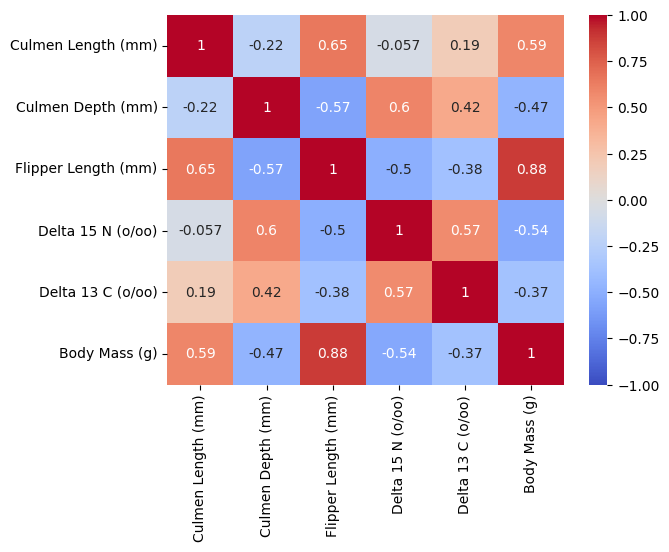

In [3]:
sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True, cmap="coolwarm")

## Finding correlation through regularization
We will start with an unfortunate dataset. We have 500 datapoints, and 100 features. But there is a lot of noise, and a lot of features arent even correlated to the target!

In real life situations, this might happen more often than you like; you get an abundance of features, and you have no idea what is correlated, and what is just noise.

In [4]:

datafile = Path("../data/sim/correlation.csv")
df = pd.read_csv(datafile)
df.shape

(500, 101)

You might think, lets start with plotting the correlations. Because we have a 100 features, this is too much for a heatmap, so we will limit ourselves to the correlation between the features and the target.

([], [])

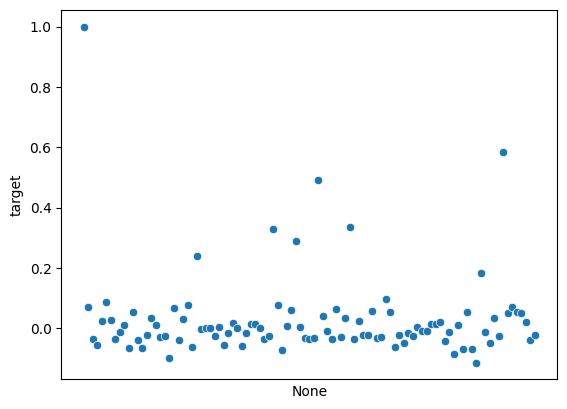

In [5]:
correlation_matrix = df.corr()
sns.scatterplot(x=correlation_matrix.index, y=correlation_matrix.target)
plt.xticks([])

The target has obviously a correlation of 1 with itself. But the other features are much more noisy. 6 features have a correlation above 0.2, but that is still not very high.
Maybe the two features with a correlation above 0.5 are worth looking at, but the rest might be noise if you use this method. Because this is synthetic data that I created myself, I know for a fact that 10 out of 100 features are relevant. So, for this case plain correlation is not very good at finding the relevant features.

However, there are smarter ways of figuring out a correlation. First, let's split the data into features X and target y

In [6]:
X = df.drop(columns=["target"]).values
y = df["target"].values

X.shape, y.shape

((500, 100), (500,))

## (mis)using a linear regression for feature selection
What we will do, is we will construct a linear regression for this problem. 

Note that in this strategy, our goal is NOT to create a linear regression model. Well, we might want to do that, but that is not the point here. We are trying to get a better grip on correlation, and which features contain relevant information. We might already have decided we are going to use a random forest, or a neural network, or whatever fits our goal, or we might not have decided yet. In using a linear regression model, we are going to use regularization, and we are going to read out the weights of the model.

These weights is what we are actually interested in, because it will tell us something about how informative the models are. If a weight is zero, it means that the feature is not used in the model. If a weight is high, it means that the feature is used a lot in the model. If a weight is negative, it means that the feature is used inversely in the model.

This means we are going to assume there is a relation like this:

$$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_{100} x_{100}$$

Where $\beta$ are the weights we want to learn.

We are going to define a "loss" function. This function tells us how good or bad our model is working. The better the model, the lower the loss. The worse the model, the higher the loss. The mean squared error is a common loss function, that calculates the average of the squared differences between the predictions and the actual values:

$$L = \frac{1}{n} \sum_i (y_i - \hat{y}_i)^2$$

# Using regularization
But a 100 features is a lot, especially compared to 500 data points. So we are going to restrain the weights by adding a penalty to the loss function. This is called regularization. 

## L2 regularization
Ridge regression (often called "l2") looks like this:

$$L = \frac{1}{n} \sum_i (y_i - \hat{y}_i)^2 + \alpha \frac{1}{2} \sum_j \beta_j^2$$ 


The first part is the normal loss function, the second part $\alpha \frac{1}{2} \sum_j \beta_j^2$ is the regularization.
The $\frac{1}{2}$ helps with taking the gradient of the function: as you might remember from school when you were 16, the derivative of $a^2$ is $2a$, but the derivartive of 
$\frac{1}{2}a^2$ is $\frac{1}{2} 2 a$, which is simplified to just $a$ which is convenient.

What we actually do is adding the square of every weight as a penalty.

Can you understand what this does? The weights are an additional term that we try to minimize.
If two models are almost equally good, but one of them has lower weights, this model will be preferred.
$\alpha$ is a hyperparameter that controls the strength of the regularization. The higher $\alpha$, the more the weights will be restrained.


## L1 regularization
Another way of regularization is Lasso (often called "l1"):

$$L = \frac{1}{n} \sum_i (y_i - \hat{y}_i)^2 + \alpha \sum_j |\beta_j|$$

You notice the same mean square error loss function $\frac{1}{n} \sum_i (y_i - \hat{y}_i)^2$, but now we are adding the summed ($\Sigma$) absolute value (the $||$ mean absolute value. $|x|$ is always positive, even if $x$ is negative) of the weights $\beta$ as a penalty, where $\alpha$ is a parameter that determines if this part has a lot of impact (when $\alpha$ is big) or almost no impact (when $\alpha$ is small): $\alpha \sum_j |\beta_j|$

## Elasticnet
The difference between l1 and l2 is that l1 will tend to generate more sparse weights. That is why l1 if often used for feature selection. Another option is to simply mix the two strategies, and search for a parameter that balances the two. This combination is called ElasticNet.

$$L = \frac{1}{n} \sum_i (y_i - \hat{y}_i)^2 + r\alpha \sum_j |\beta_j| + \alpha \frac{1-r}{2} \sum_j \beta_j^2$$

This formula looks impressive, but lets break it down:

- the first part is the usual loss function $\frac{1}{n} \sum_i (y_i - \hat{y}_i)^2$
- the second part is the l1 regularization $\alpha \sum_j |\beta_j|$. If $r$ is zero, this is removed from the equation.
- the third part is the l2 regularization $\alpha \frac{1-r}{2} \sum_j \beta_j^2$. If $r$ is one, this is removed from the equation. 

Now, we can pick a value between 0 and 1 for r, and this will balance the two regularization strategies.

First, let's use it with default values

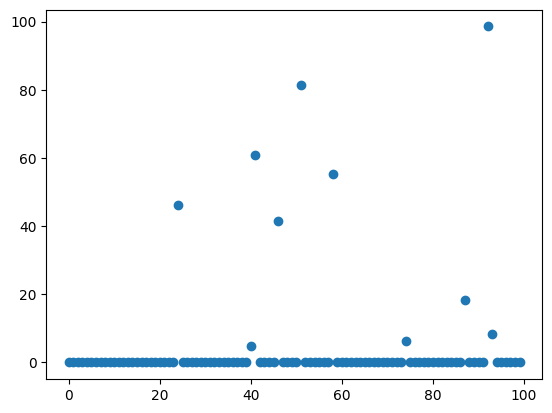

In [7]:
from sklearn.linear_model import SGDRegressor

regressor = SGDRegressor(penalty="elasticnet", random_state=42)
regressor.fit(X, y)
coef = regressor.coef_
plt.plot(coef.T, "o")

I think this is an impressive improvement over using simple correlation!

We have the option to try different values for $r$ and $\alpha$. While creating models and hypertuning is a topic for the next semester, I will show it here so you already have a look at it.

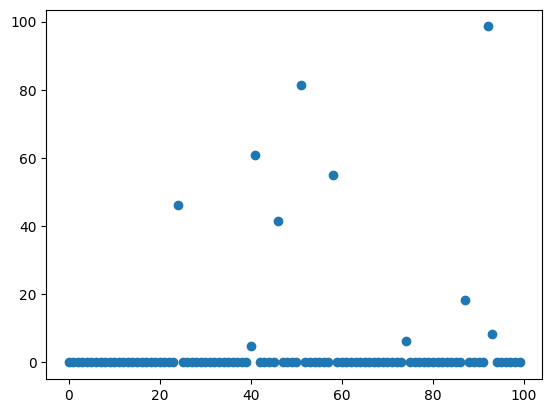

In [8]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV


l1_ratio = [0.1, 0.15, 0.3, 0.6, 0.75, 0.9, 0.95, 0.99, 1]
alphalist = [0.001, 0.01, 0.1, 1, 10, 100]

regressor = SGDRegressor(penalty="elasticnet", random_state=42)
param_grid = {"alpha":alphalist, "l1_ratio":l1_ratio}

grid = GridSearchCV(
    regressor,
    param_grid=param_grid,
    cv=5,
)


grid.fit(X, y)
best_model = grid.best_estimator_
coef = best_model.coef_
plt.plot(coef.T, "o")

In [9]:
grid.best_params_

{'alpha': 0.01, 'l1_ratio': 1}

If we look at the result, you can see that the grid picked `l1_ratio = 1`, which means that the search found the L1 regularisation to be the best one for this problem.
